In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [29]:
matplotlib.rcParams.update({'font.size': 26})

## Read prepared B data for track-based and vertex-based tagging

In [3]:
import pandas
Bdata_tracks = pandas.read_csv('models/Bdata_tracks_PID_less.csv')
Bdata_vertex = pandas.read_csv('models/Bdata_vertex.csv')

In [4]:
Bdata_tracks.head()

,Bsign,Bweight,event_id,track_relation_prob
0,1,1.091776,111761_12239990,0.688861
1,1,-0.237732,111761_14379738,0.954897
2,1,-0.417194,111761_16432326,1.549822
3,-1,1.044602,111761_29035939,1.538230
4,-1,1.062837,111761_30938577,0.656946


In [5]:
Bdata_vertex.head()

,Bsign,Bweight,event_id,vertex_relation_prob
0,1,1.091776,111761_12239990,1.410856
1,1,-0.237732,111761_14379738,0.360223
2,1,-0.442830,111761_33866816,1.278433
3,-1,0.991477,111761_43041334,0.928330
4,-1,1.091055,111761_48273537,0.821604


### Merge two datasets

In [6]:
Bdata = pandas.merge(Bdata_tracks, Bdata_vertex, how='outer', on=['event_id', 'Bsign'])

In [7]:
Bdata.head()

,Bsign,Bweight_x,event_id,track_relation_prob,Bweight_y,vertex_relation_prob
0,1,1.091776,111761_12239990,0.688861,1.091776,1.410856
1,1,-0.237732,111761_14379738,0.954897,-0.237732,0.360223
2,1,-0.417194,111761_16432326,1.549822,NaN,NaN
3,-1,1.044602,111761_29035939,1.538230,NaN,NaN
4,-1,1.062837,111761_30938577,0.656946,NaN,NaN


### Obtain one weight column

In [8]:
Bdata['Bweight'] = Bdata['Bweight_x'].copy()
Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight'] = Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight_y']
Bdata = Bdata.drop(['Bweight_x', 'Bweight_y'], axis=1)

# for Nan put 1 as non influence factor
Bdata.ix[numpy.isnan(Bdata.track_relation_prob.values), 'track_relation_prob'] = 1.
Bdata.ix[numpy.isnan(Bdata.vertex_relation_prob.values), 'vertex_relation_prob'] = 1.

In [9]:
Bdata.head()

,Bsign,event_id,track_relation_prob,vertex_relation_prob,Bweight
0,1,111761_12239990,0.688861,1.410856,1.091776
1,1,111761_14379738,0.954897,0.360223,-0.237732
2,1,111761_16432326,1.549822,1.000000,-0.417194
3,-1,111761_29035939,1.538230,1.000000,1.044602
4,-1,111761_30938577,0.656946,1.000000,1.062837


In [10]:
relation_prob = Bdata['track_relation_prob'].values * Bdata['vertex_relation_prob'].values
Bprob = relation_prob / (1 + relation_prob)
Bweight = Bdata.Bweight.values
Bsign = Bdata.Bsign.values

In [11]:
sum(Bdata['vertex_relation_prob'].values == 0)

7

In [12]:
Bprob[~numpy.isfinite(Bprob)] = 0.5
Bprob[~numpy.isfinite(Bprob)] = 0.5

## 2-folding calibration by isotonic

In [13]:
from utils import calibrate_probs
Bprob_calibrated, (iso_reg1, iso_reg2) = calibrate_probs(Bsign, Bweight, Bprob,
                                                         symmetrize=True, return_calibrator=True)

In [14]:
Bprob_calibrated_log, (log_reg1, log_reg2) = calibrate_probs(Bsign, Bweight, Bprob, logistic=True,
                                                             symmetrize=True, return_calibrator=True)

In [18]:
from sklearn.metrics import log_loss, mean_squared_error
def log_loss_new(y, p, sample_weight):
    p_new = numpy.zeros(shape=(len(y), 2))
    p_new[:, 1] = p
    p_new[:, 0] = 1 - p
    return log_loss(y, p_new, sample_weight=sample_weight)

In [20]:
print 'before', log_loss_new(Bsign > 0, Bprob, sample_weight=Bweight)
print 'after', log_loss_new(Bsign > 0, Bprob_calibrated, sample_weight=Bweight)
print 'after log', log_loss_new(Bsign > 0, Bprob_calibrated_log, sample_weight=Bweight)

 before 0.660400719187
after 0.660098804924
after log 0.660233669541


In [21]:
print 'before', mean_squared_error(Bsign > 0, Bprob, sample_weight=Bweight)
print 'after', mean_squared_error(Bsign > 0, Bprob_calibrated, sample_weight=Bweight)
print 'after log', mean_squared_error(Bsign > 0, Bprob_calibrated_log, sample_weight=Bweight)

before 0.23427094805
after 0.234094109697
after log 0.234169307


(0.3, 0.5)

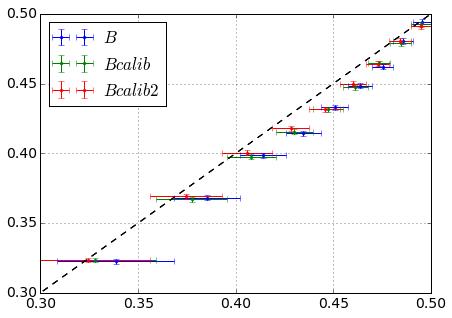

In [58]:
figure(figsize=(7, 5))
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", bins=percentile_bins, uniform=False)
compute_mistag(Bprob_calibrated_log, Bsign, Bweight, Bsign > -100, label="$B calib$", bins=percentile_bins, uniform=False)
compute_mistag(Bprob_calibrated_log2, Bsign, Bweight, Bsign > -100, label="$B calib2$", bins=percentile_bins, uniform=False)
legend(loc='best')
xlim(0.3, 0.5); ylim(0.3, 0.5)

#### without noise

(<matplotlib.legend.Legend at 0x7f2584e46790>,
 <matplotlib.text.Text at 0x7f2584e24110>)

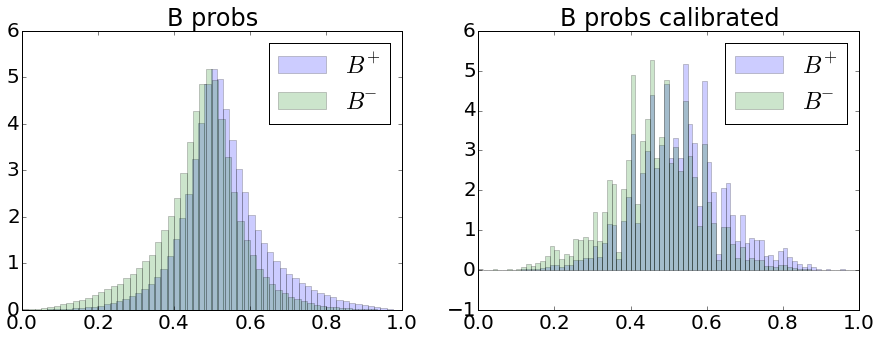

In [14]:
figure(figsize=(15, 5))

subplot(1,2,1)
hist(Bprob[Bsign == 1], weights=Bweight[Bsign == 1], bins=60, alpha=0.2, normed=True, label='$B^+$')
hist(Bprob[Bsign == -1], weights=Bweight[Bsign == -1], bins=60, alpha=0.2, normed=True, label='$B^-$')
legend(), title('B probs')

subplot(1,2,2)
hist(Bprob_calibrated[Bsign == 1], weights=Bweight[Bsign == 1], bins=80, alpha=0.2, 
     normed=True, range=(0, 1), label='$B^+$')
hist(Bprob_calibrated[Bsign == -1], weights=Bweight[Bsign == -1], bins=80, alpha=0.2,
     normed=True, range=(0, 1), label='$B^-$')
legend(), title('B probs calibrated')
# plt.savefig('img/Bprob_iso_calibrated_PID_less.png' , format='png')

#### Add some small noise in prediction for stability

In [15]:
Bprob_calibrated = Bprob_calibrated + numpy.random.normal(size=len(Bprob_calibrated)) * 0.001

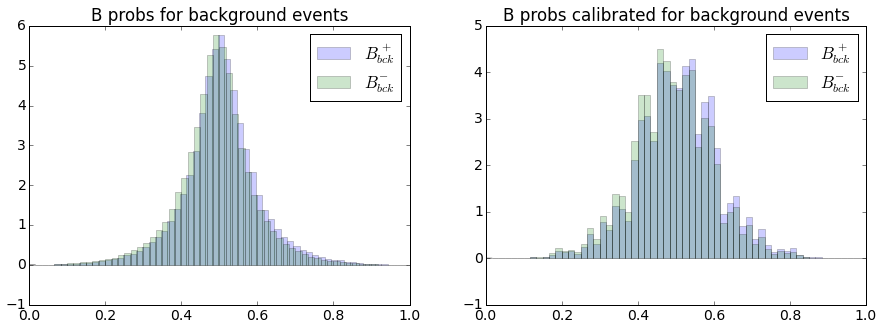

In [15]:
figure(figsize=(15, 5))

subplot(1,2,1)
hist(Bprob[Bsign == 1], weights=1 - Bweight[Bsign == 1], bins=60, alpha=0.2, normed=True, label='$B^+_{bck}$')
hist(Bprob[Bsign == -1], weights=1 - Bweight[Bsign == -1], bins=60, alpha=0.2, normed=True, label='$B^-_{bck}$')
legend(), title('B probs for background events')

subplot(1,2,2)
hist(Bprob_calibrated[Bsign == 1], weights=1 - Bweight[Bsign == 1], bins=60, alpha=0.2, 
     normed=True, range=(0, 1), label='$B^+_{bck}$')
hist(Bprob_calibrated[Bsign == -1], weights=1 - Bweight[Bsign == -1], bins=60, alpha=0.2,
     normed=True, range=(0, 1), label='$B^-_{bck}$')
legend(), title('B probs calibrated for background events')
plt.savefig('img/Bprob_iso_calibrated_PID_less_bck.png' , format='png')

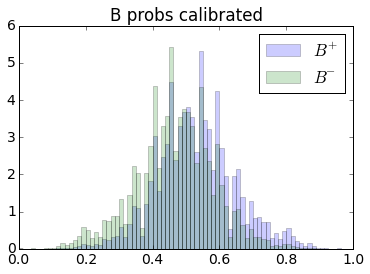

In [16]:
hist(Bprob_calibrated[Bsign == 1], weights=Bweight[Bsign == 1], bins=80, alpha=0.2, 
     normed=True, range=(0, 1), label='$B^+$')
hist(Bprob_calibrated[Bsign == -1], weights=Bweight[Bsign == -1], bins=80, alpha=0.2,
     normed=True, range=(0, 1), label='$B^-$')
legend(), title('B probs calibrated')
ylim(0, 6)
plt.savefig('../for_Bassem/Bprob_calibrated_pdf_for_summary.pdf' , format='pdf')

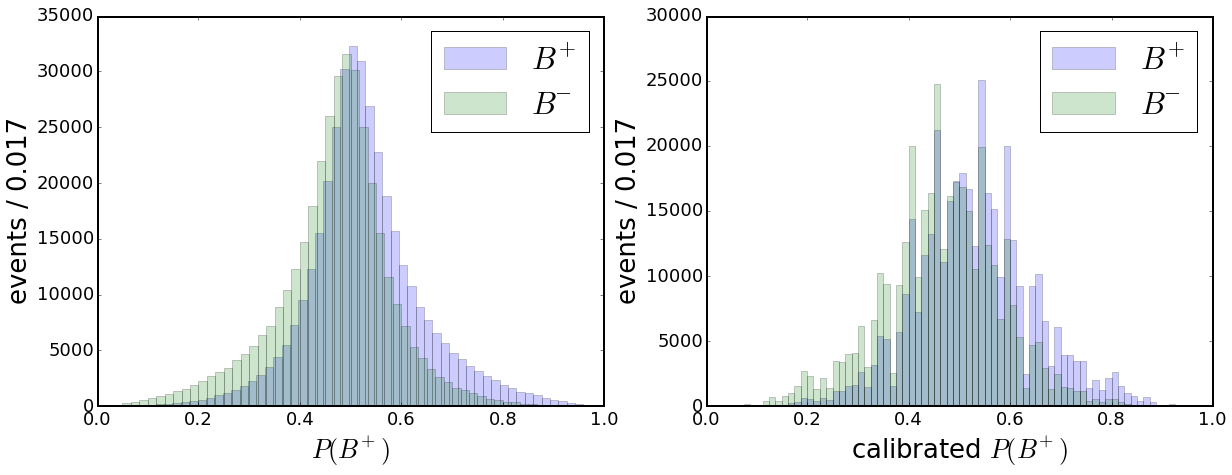

In [81]:
figure(figsize=(20, 7))

subplot(1,2,1)
hist(Bprob[Bsign == 1], weights=Bweight[Bsign == 1], bins=60, alpha=0.2,  label='$B^+$')
hist(Bprob[Bsign == -1], weights=Bweight[Bsign == -1], bins=60, alpha=0.2,  label='$B^-$')
legend(), xlabel('$P(B^+)$'), ylabel('events / 0.017')
xticks(fontsize=18), yticks(fontsize=18)
axvline(linewidth=2, x=0.002, color='black');
axhline(linewidth=3, y=0., color='black')
axvline(linewidth=3, x=1, color='black');
axhline(linewidth=2, y=35000 - 100, color='black')

subplot(1,2,2)
hist(Bprob_calibrated[Bsign == 1], weights=Bweight[Bsign == 1], bins=80, alpha=0.2, 
      range=(0, 1), label='$B^+$')
hist(Bprob_calibrated[Bsign == -1], weights=Bweight[Bsign == -1], bins=80, alpha=0.2,
      range=(0, 1), label='$B^-$')
ylim(0, )
xticks(fontsize=18), yticks(fontsize=18)
axvline(linewidth=2, x=0.002, color='black');
axhline(linewidth=3, y=0., color='black')
axvline(linewidth=3, x=1, color='black');
axhline(linewidth=2, y=30000 - 100, color='black')
legend(), xlabel('calibrated $P(B^+)$'), ylabel('events / 0.017')
# plt.savefig('img/Bprob_iso_calibrated_PID_less.png' , format='png')
plt.savefig('img/paper_B_prob.png', dpi=300, format='png', bbox_inches='tight')

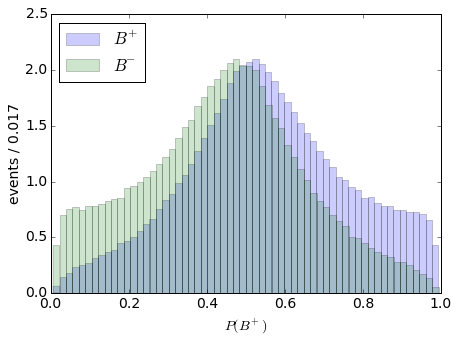

In [30]:
figure(figsize=(7, 5))
hist(0.5 * (numpy.tanh(5 * (Bprob[Bsign == 1] - 0.5)) + 1), weights=Bweight[Bsign == 1], bins=60, alpha=0.2, normed=True, label='$B^+$')
hist(0.5 * (numpy.tanh(5 * (Bprob[Bsign == -1] - 0.5)) + 1), weights=Bweight[Bsign == -1], bins=60, alpha=0.2, normed=True, label='$B^-$')
legend(loc='upper left'), xlabel('$P(B^+)$'), ylabel('events / 0.017')
# plt.savefig('img/Bprob_iso_calibrated_PID_less.png' , format='png')
plt.savefig('img/poster_B_prob2.png' , dpi=700, format='png', transparent=True)

## AUC score and ROC curve for B+ vs B-

AUC for tagged: 0.640672547156 AUC with untag: 0.640660473739


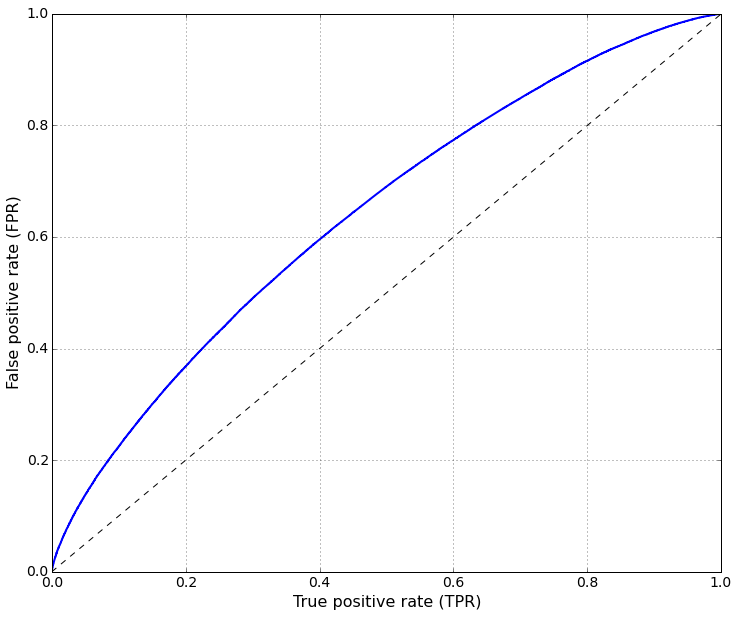

In [72]:
from utils import calculate_auc_with_and_without_untag_events, calculate_roc_with_untag_events
from sklearn.metrics import roc_curve

auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob_calibrated, Bweight)
print 'AUC for tagged:', auc, 'AUC with untag:', auc_full

figure(figsize=(12, 10))
fpr, tpr, _ = calculate_roc_with_untag_events(Bsign, Bprob_calibrated, Bweight)
plot(fpr, tpr, linewidth=2)
plot([0, 1], [0, 1], 'k--')
ylim(0, 1), xlim(0, 1)
xlabel('True positive rate (TPR)', fontsize=16)
ylabel('False positive rate (FPR)', fontsize=16)
grid()
plt.savefig('img/poster_B_roc.png' , dpi=700, format='png', transparent=True)

In [73]:
import cPickle
with open('models/inclusive_roc', 'w') as f:
    cPickle.dump((fpr, tpr), f)

## Symmetry $B^+$ vs $B^-$ checking

### before calibration

(<matplotlib.legend.Legend at 0x7f4bfd91e750>,
 <matplotlib.text.Text at 0x7f4c0352c210>)

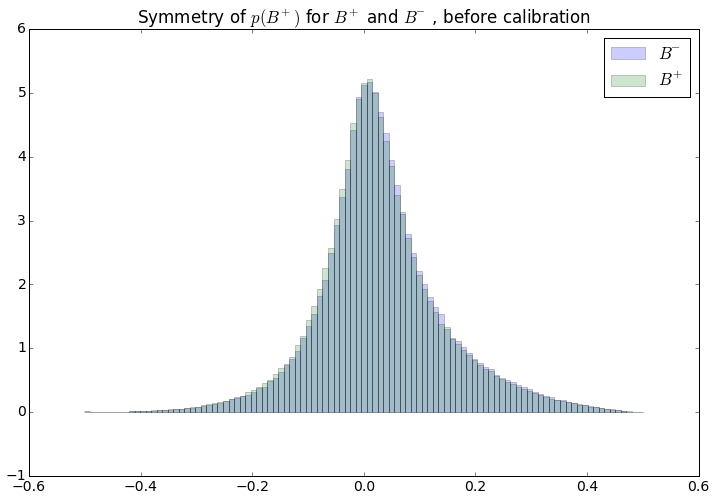

In [23]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob[Bsign == sign] - 0.5), bins=101, normed=True, alpha=0.2, 
         weights=Bweight[Bsign == sign], range=(-0.5, 0.5), label='$B^-$' if sign == -1 else '$B^+$')
legend(), title('Symmetry of $p(B^+)$ for $B^+$ and $B^-$, before calibration')

#### KS distance

In [24]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob - 0.5) * Bsign, sample_weight=Bweight)

In [25]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.016313414800268822)

((0, 1), (0, 1))

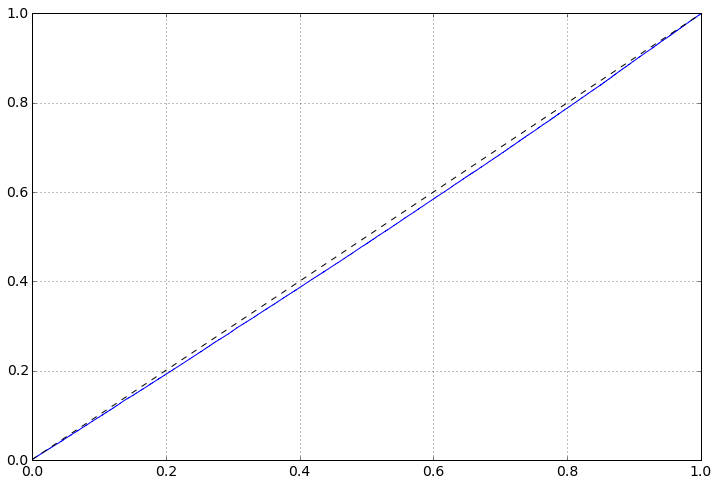

In [26]:
plot(fpr, tpr), grid()
plot([0, 1], [0, 1], 'k--')
xlim(0, 1), ylim(0, 1)


In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Bsign, (Bprob - 0.5) * Bsign, sample_weight=Bweight)

0.48957257623263567

### after calibration

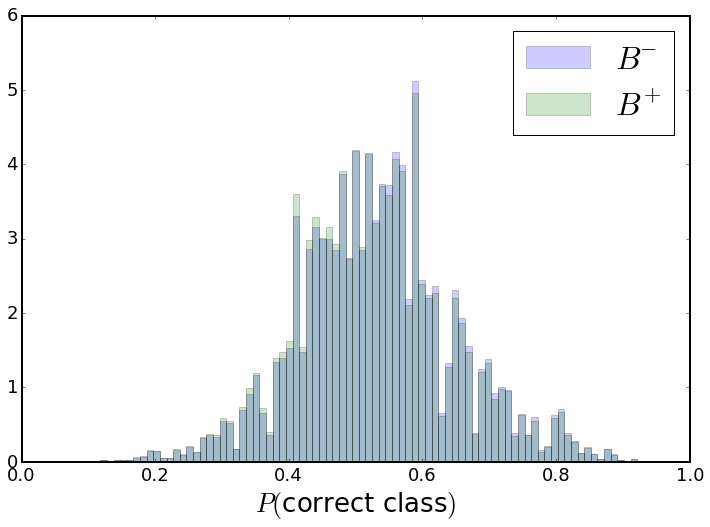

In [199]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob_calibrated[Bsign == sign] - 0.5) + 0.5, bins=101,  alpha=0.2,
         weights=Bweight[Bsign == sign], range=(0, 1), normed=True, label='$B^-$' if sign == -1 else '$B^+$')
legend(fontsize=32); ylim(0, ), xlim(0, 1)
xticks(fontsize=18), yticks(fontsize=18)
axvline(linewidth=2, x=0 + 0.002, color='black');
axhline(linewidth=3, y=0, color='black')
axvline(linewidth=3, x=1, color='black');
axhline(linewidth=2, y=5.997, color='black')
xlabel('$P($correct class$)$', fontsize=26)
plt.savefig('img/paper_symmetry.png' , dpi=300, format='png',  bbox_inches='tight')

#### KS distance

In [30]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob_calibrated - 0.5) * Bsign, sample_weight=Bweight)

In [31]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.016392311317996677)

((0, 1), (0, 1))

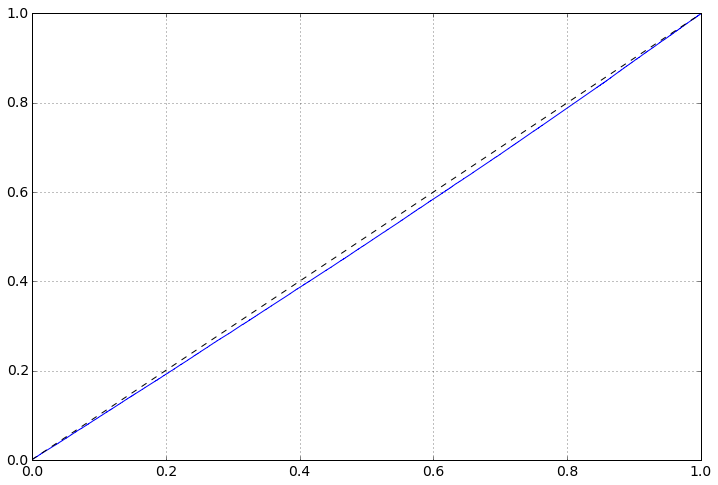

In [32]:
plot(fpr, tpr), grid()
plot([0, 1], [0, 1], 'k--')
xlim(0, 1), ylim(0, 1)

In [33]:
roc_auc_score(Bsign, (Bprob_calibrated - 0.5) * Bsign, sample_weight=Bweight)

0.4895552130434615

## D2 estimation with bootstrap calibration

In [ ]:
from utils import get_N_B_events, bootstrap_calibrate_prob, result_table

N_B_passed = Bweight.sum()
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = numpy.sqrt(N_B_passed) / get_N_B_events()

D2, aucs = bootstrap_calibrate_prob(Bsign, Bweight, Bprob, symmetrize=True)
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

result = result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full, 'Inclusive tagging, PID less')

In [27]:
result

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"Inclusive tagging, PID less",99.985947,0.116015,0.058732,0.000431,5.872386,0.043591,64.088992,0


In [ ]:
result.to_csv('img/new-tagging-PID-less.csv', header=True, index=False)

## Some plots

### Isotonic transformation, and its reverse (too check symmetry)

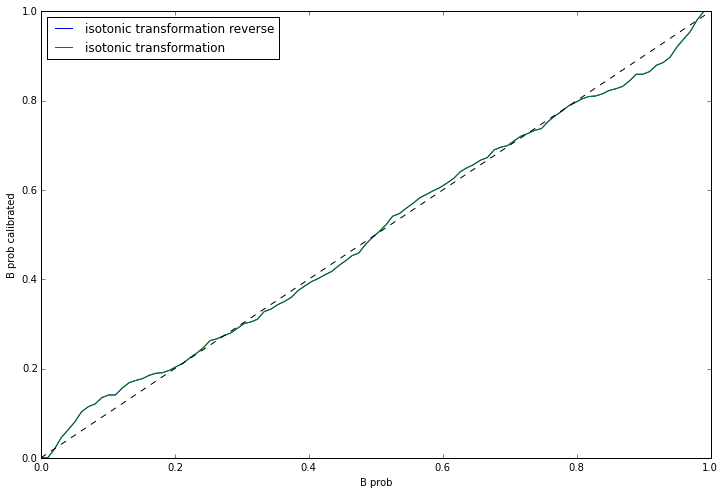

In [28]:
x = numpy.linspace(0, 1, 100)
plot(x, -(iso_reg1.transform((1-x)) + iso_reg2.transform((1-x))) / 2 + 1, label='isotonic transformation reverse')
plot(x, (iso_reg1.transform(x) + iso_reg2.transform(x)) / 2, label='isotonic transformation')
legend(loc='best')
plot([0, 1], [0, 1], "k--")
xlabel('B prob'), ylabel('B prob calibrated')
plt.savefig('img/iso_transformation_PID_less.png' , format='png')

### Mistag checking

In [17]:
from utils import get_N_B_events, compute_mistag

In [18]:
bins = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
percentile_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

### before calibration

In [19]:
figsize(12, 10)

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


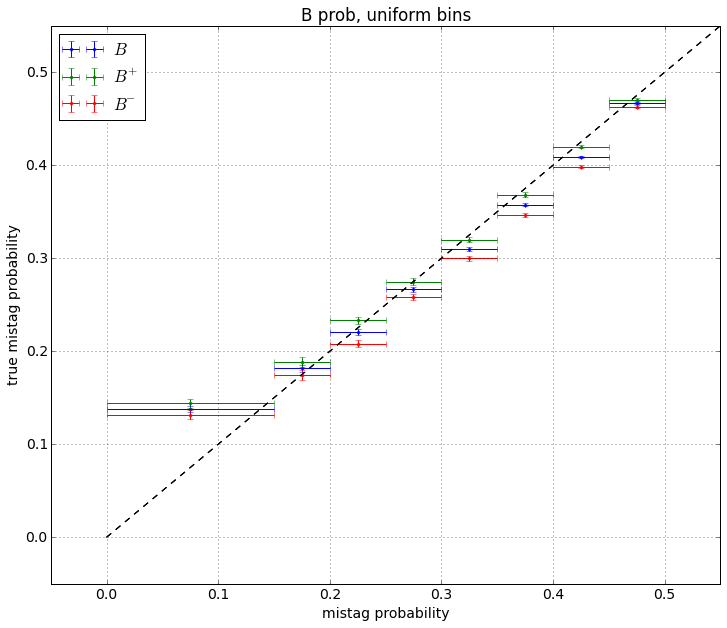

In [36]:
figsize(12, 10)
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", bins=bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", bins=bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", bins=bins)
legend(loc='best')
title('B prob, uniform bins'), xlabel('mistag probability'), ylabel('true mistag probability')
plt.savefig('img/Bprob_calibration_check_uniform_PID_less.png' , format='png')

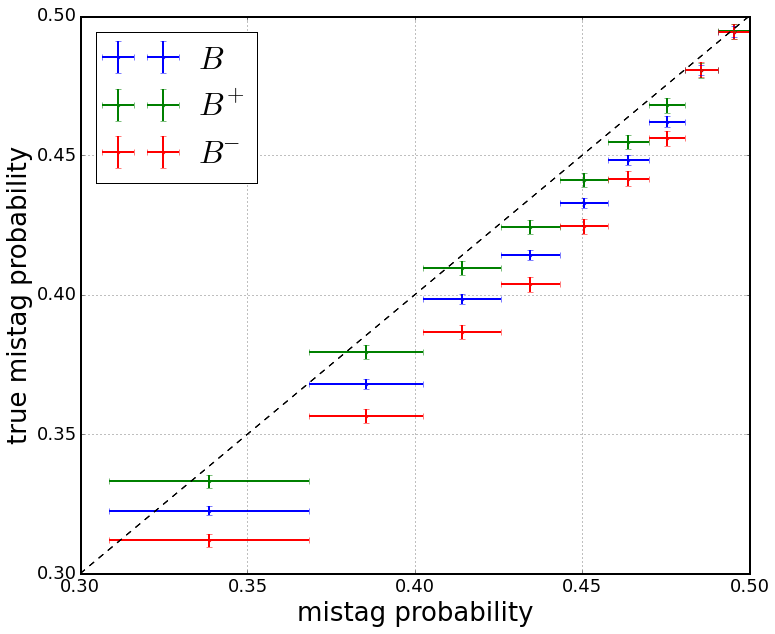

In [73]:
figure(figsize=(12, 10))
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False, bins=percentile_bins)
p1 = compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, bins=percentile_bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, bins=percentile_bins)
legend(loc='best', fontsize=32)
xticks(fontsize=18), yticks(fontsize=18)
ylabel('true mistag probability')
xlabel('mistag probability')
axvline(linewidth=2, x=0.3002, color='black');
axhline(linewidth=3, y=0.3, color='black')
axvline(linewidth=3, x=0.5, color='black');
axhline(linewidth=2, y=0.4997, color='black')

xlim(0.3, 0.5), ylim(0.3, 0.5)
# plt.savefig('img/Bprob_calibration_check_percentile_PID_less.png' , format='png')
plt.savefig('img/paper_check.png' , dpi=300, format='png', bbox_inches='tight')

### after calibration

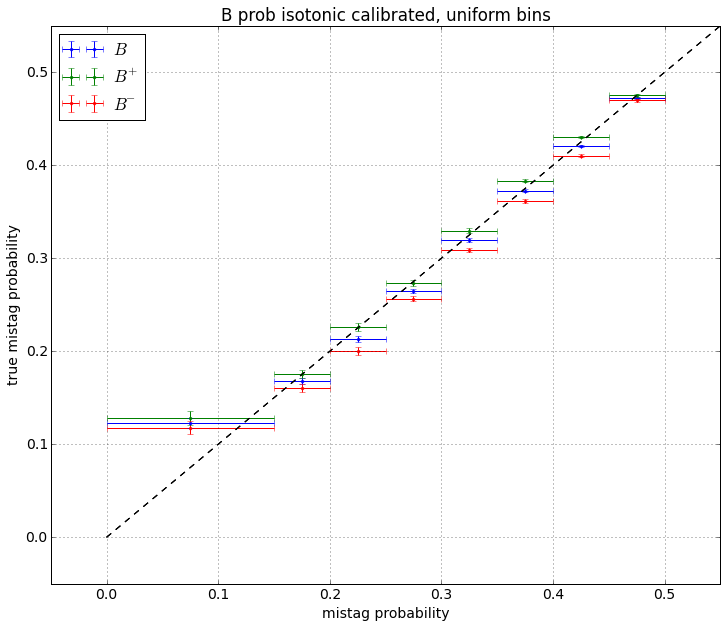

In [38]:
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", bins=bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", bins=bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", bins=bins)
legend(loc='best')
title('B prob isotonic calibrated, uniform bins'), xlabel('mistag probability'), ylabel('true mistag probability')
plt.savefig('img/Bprob_calibration_check_iso_uniform_PID_less.png' , format='png')

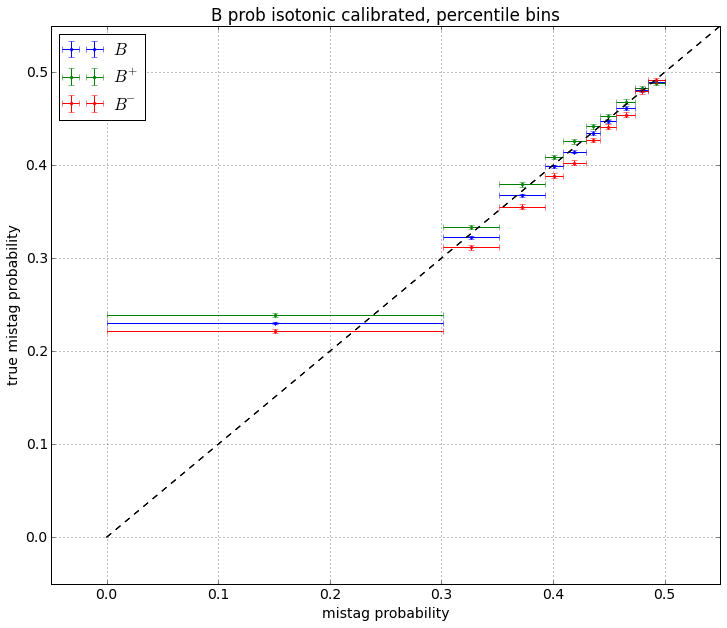

In [70]:
figsize(12, 10)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob isotonic calibrated, percentile bins')
plt.savefig('../for_Bassem/Bprob_calibration_check_iso_percentile_large.pdf' , format='pdf')

In [50]:
reload(utils)

<module 'utils' from 'utils.py'>

In [ ]:
figsize(12, 10)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best', fontsize=32),  xlabel('mistag probability', fontsize=26), ylabel('true mistag probability', fontsize=26)
xlim(0.3, 0.5), ylim(0.3, 0.5)

In [82]:
pandas.DataFrame({"p": Bprob, "p_calib": Bprob_calibrated, "weight": Bweight, "sign": Bsign}).to_csv('for_axelr.csv', sep='\t', index=False)

In [90]:
mistag_t = numpy.minimum(Bprob_calibrated, 1-Bprob_calibrated)

In [169]:
perc = numpy.percentile(Bprob_calibrated, percentile_bins)

In [94]:
mask =(mistag_t > a[0]) & (mistag_t < a[1])

In [104]:
tag = (numpy.argmax([1-Bprob_calibrated, Bprob_calibrated], axis=0) - 0.5) * 2

In [127]:
from sklearn.metrics import roc_auc_score

In [132]:
a = Bprob_calibrated[mask * (Bsign == 1)]
b = 1 - Bprob_calibrated[mask * (Bsign == -1)]
roc_auc_score([0] * len(a) + [1] * len(b), numpy.concatenate([a, b]))

0.51354774121444124

(array([  4.01568525,   9.04811817,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         13.67773458,   6.8873994 ]),
 array([ 0.3513201 ,  0.38105639,  0.41079269,  0.44052898,  0.47026528,
         0.50000157,  0.52973787,  0.55947416,  0.58921046,  0.61894675,
         0.64868305]),
 <a list of 10 Patch objects>)

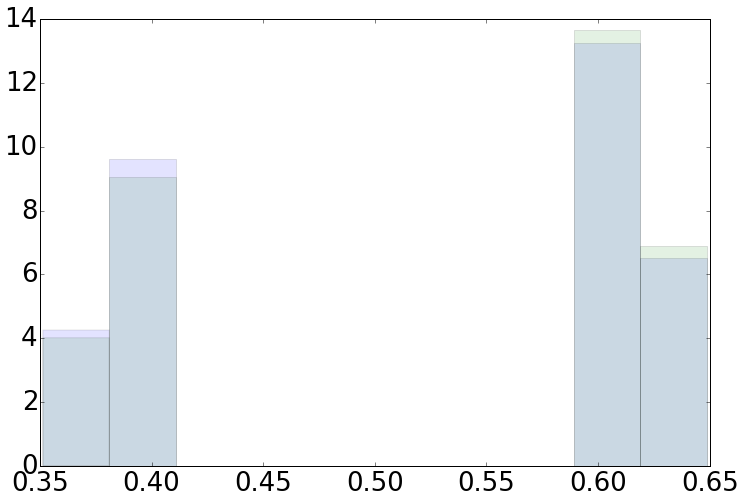

In [126]:
hist(Bprob_calibrated[mask * (Bsign == 1)], alpha=0.11, normed=True)
hist(1 - Bprob_calibrated[mask * (Bsign == -1)], alpha=0.11, normed=True)

In [141]:
sum(Bweight[(Bsign == 1) & mask]), sum(Bweight[(Bsign == -1) & mask])

(73909.395762359985, 71578.268546849999)

In [146]:
73909.395762359985 - 71578.268546849999

2331.127215509987

In [157]:
73909.395762359985 / (73909.395762359985 + 71578.268546849999), 71578.268546849999 / (71578.268546849999 + 73909.395762359985)

(0.5080114256647752, 0.4919885743352249)

In [110]:
97009 / (100001. + 97009)

0.4924064768285874

In [107]:
print sum(tag[(Bsign == 1) & mask] == 1), sum(tag[(Bsign == 1) & mask] == -1)
print sum(tag[(Bsign == -1) & mask] == -1), sum(tag[(Bsign == -1) & mask] == 1)

58751 41250
59324 37685


In [148]:
59324 - 58751, 41250 - 37685

(573, 3565)

In [137]:
print sum(Bweight[(Bsign == 1) & mask & (tag == 1)]), sum(Bweight[(Bsign == 1) & mask & (tag == -1)])
print sum(Bweight[(Bsign == -1) & mask & (tag == -1)]), sum(Bweight[(Bsign == -1) & mask & (tag == 1)])

44847.0883034 29062.307459
45036.3311445 26541.9374023


In [139]:
44847.0883034 / (44847.0883034 + 29062.307459) - 45036.3311445 / (45036.3311445 + 26541.9374023)

-0.02240533518703136

In [140]:
sqrt(44847.0883034) / (44847.0883034 + 29062.307459), sqrt(45036.3311445) / (45036.3311445 + 26541.9374023)

(0.0028652826768207737, 0.0029648335272149419)

In [ ]:
2.24 - 0.6 = 1.66

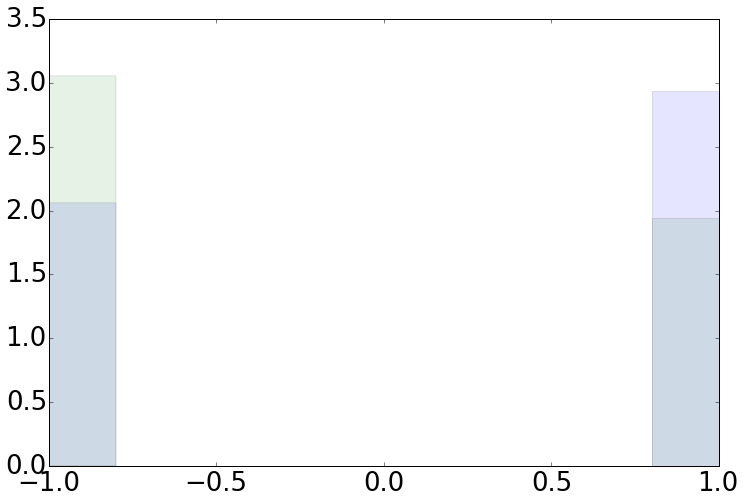

In [117]:
hist(tag[(Bsign == 1) & mask], alpha=0.1, normed=True)
hist(tag[(Bsign == -1) & mask], alpha=0.1, normed=True)
pass

In [163]:
print sum(Bweight[(Bprob_calibrated < 0.5) & (Bsign == 1) & mask])
print sum(Bweight[(1 - Bprob_calibrated < 0.5) & (Bsign == -1) & mask])
print sum(Bweight[(Bprob_calibrated > 0.5) & (Bsign == 1) & mask])
print sum(Bweight[(1 - Bprob_calibrated > 0.5) & (Bsign == -1) & mask])

29062.307459
26541.9374023
44847.0883034
45036.3311445


In [164]:
29062.307459 + 44847.0883034, 45036.3311445 + 26541.9374023

(73909.3957624, 71578.2685468)

In [165]:
29062.307459 / (29062.307459 + 26541.9374023)

0.5226634680768244

In [ ]:
sum[Bweight[(Bsign == 1)] ]

In [184]:
a = numpy.histogram(Bprob_calibrated[(Bsign == 1)], bins=[0] + list(perc) + [1], weights=Bweight[(Bsign == 1)], normed=True)[0]
b = numpy.histogram(1 - Bprob_calibrated[(Bsign == -1)], bins=[0] + list(perc) + [1], weights=Bweight[(Bsign == -1)], normed=True)[0]
a / (a+b), b / (a+b)

(array([ 0.5170399 ,  0.51818602,  0.5161673 ,  0.51111556,  0.50495698,
         0.50448622,  0.49840986,  0.49646446,  0.4956128 ,  0.49154887]),
 array([ 0.4829601 ,  0.48181398,  0.4838327 ,  0.48888444,  0.49504302,
         0.49551378,  0.50159014,  0.50353554,  0.5043872 ,  0.50845113]))

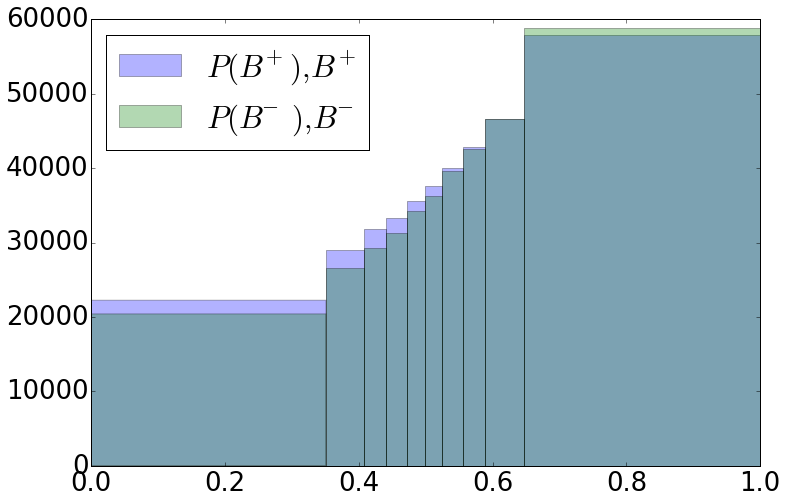

In [188]:
hist(Bprob_calibrated[(Bsign == 1)], bins=[0] + list(perc) + [1], weights=Bweight[(Bsign == 1)], alpha=0.3,  label='$P(B^+), B^+$')
hist(1 - Bprob_calibrated[(Bsign == -1)], bins=[0] + list(perc) + [1], weights=Bweight[(Bsign == -1)], alpha=0.3, label='$P(B^-), B^-$')
legend(loc='best')

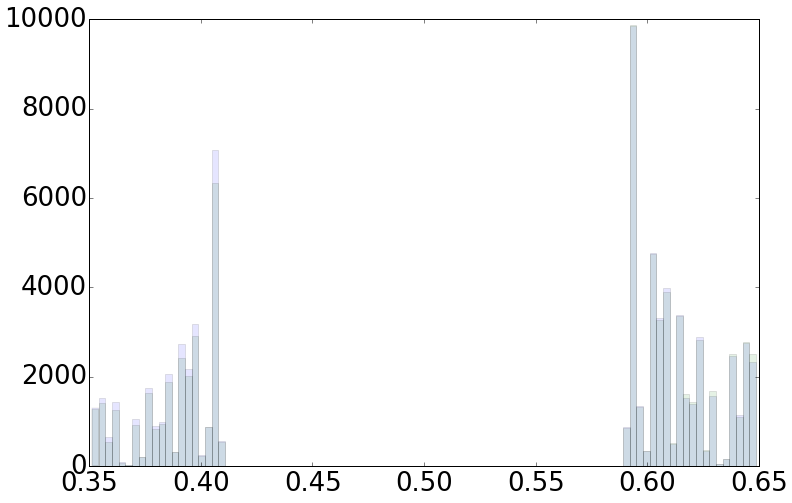

In [159]:
hist(Bprob_calibrated[(Bsign == 1) & mask], alpha=0.1, bins=100, weights=Bweight[(Bsign == 1) & mask])
hist(1 - Bprob_calibrated[(Bsign == -1) & mask], alpha=0.1, bins=100, weights=Bweight[(Bsign == -1) & mask])
pass

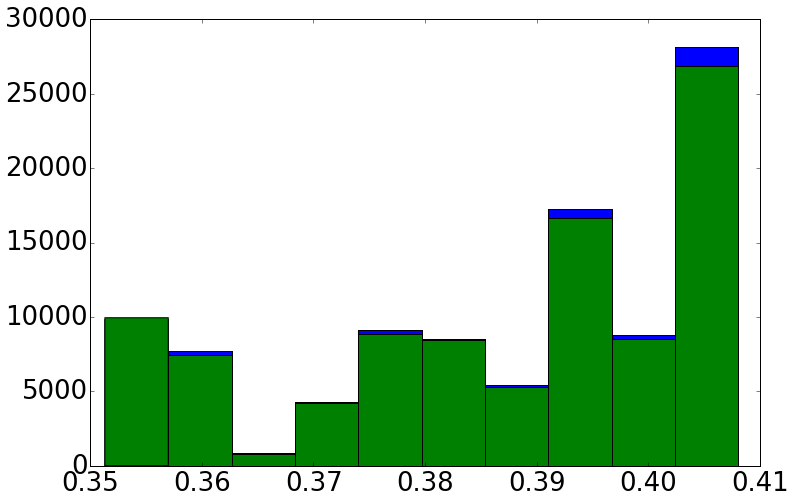

In [95]:
hist(mistag_t[(Bsign == 1) & mask])
hist(mistag_t[(Bsign == -1) & mask])
pass

In [96]:
compute_mistag??

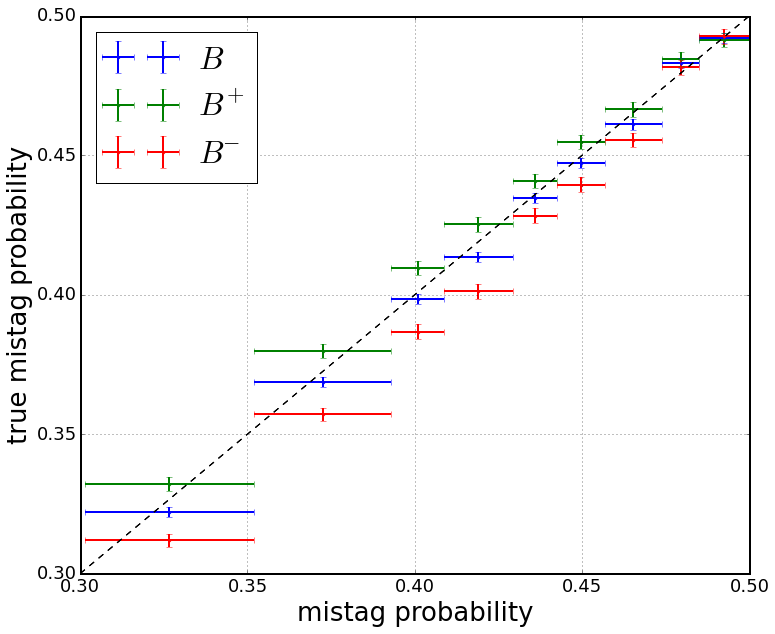

In [74]:
figsize(12, 10)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best', fontsize=32),  xlabel('mistag probability', fontsize=26), ylabel('true mistag probability', fontsize=26)
xlim(0.3, 0.5), ylim(0.3, 0.5)
xticks(fontsize=18), yticks(fontsize=18)
axvline(linewidth=2, x=0.3002, color='black');
axhline(linewidth=3, y=0.3, color='black')
axvline(linewidth=3, x=0.5, color='black');
axhline(linewidth=2, y=0.4997, color='black')
# plt.savefig('img/Bprob_calibration_check_iso_percentile_PID_less.png' , format='png')
plt.savefig('img/paper_check_calib.png' , dpi=300, format='png', bbox_inches='tight')

In [35]:
print numpy.average((2*(Bprob - 0.5))**2, weights=Bweight) * tagging_efficiency * 100
print numpy.average((2*(Bprob_calibrated - 0.5))**2, weights=Bweight) * Bweight.sum() / get_N_B_events() * 100 

5.49642770391
5.87240693118


## Flatness investigation

In [45]:
import root_numpy
data_full = pandas.DataFrame(root_numpy.root2array('datasets/tracks.root', 'tracks', 
                                                   branches=['run', 'event', 'Bmass', 'ptB', 'ghostProb']))

In [46]:
data_tau = pandas.DataFrame(root_numpy.root2array('datasets/BuJpsiK_2011and2012_3gaussMass.root', 'DecayTree', 
                                                  branches=['runNumber', 'eventNumber', 'time', 'sigmat', 'B_P', 
                                                            'B_Pt', 'nTracks']))

In [47]:
event_id_column = 'event_id'
event_id = data_full.run.apply(str) + '_' + data_full.event.apply(str)
data_full = data_full.ix[numpy.unique(event_id, return_index=True)[1], :]

In [48]:
data_full.index = numpy.unique(event_id)

In [49]:
event_id = data_tau.runNumber.apply(str) + '_' + data_tau.eventNumber.apply(str)
data_tau = data_tau.ix[numpy.unique(event_id, return_index=True)[1], :]

In [50]:
data_tau.index = numpy.unique(event_id)

In [51]:
Bmass = data_full.ix[Bdata.event_id, 'Bmass'].values
Bpt = data_full.ix[Bdata.event_id, 'ptB'].values

In [52]:
tau = data_tau.ix[Bdata.event_id, 'time'].values
Bp = data_tau.ix[Bdata.event_id, 'B_P'].values
tau_error = data_tau.ix[Bdata.event_id, 'sigmat'].values
ntracks = data_tau.ix[Bdata.event_id, 'nTracks'].values
Bpt_mirco = data_tau.ix[Bdata.event_id, 'B_Pt'].values / 1000.

In [53]:
set(Bdata.event_id).issubset(set(data_tau.index))

False

In [54]:
x = numpy.in1d(Bdata.event_id, data_tau.index)

In [55]:
mask = ~numpy.isnan(Bpt_mirco)

In [56]:
from rep.utils import weighted_quantile

In [57]:
def compute_flatness(Bprob, Bsign, Bweight, mask, spectator, bins, label="", uniform=True):
    bins_flat = weighted_quantile(spectator, [0, 0.2, 0.4, 0.6, 0.8, 1], sample_weight=Bweight)
    for i, (left, right) in enumerate(zip(bins_flat[:-1], bins_flat[1:])):
        bin_mask = (spectator >= left) * (spectator < right)
        compute_mistag(Bprob, Bsign, Bweight, mask*bin_mask, label=label+" bin %d"% i, uniform=uniform,
                       bins=bins)
    legend(loc='best')

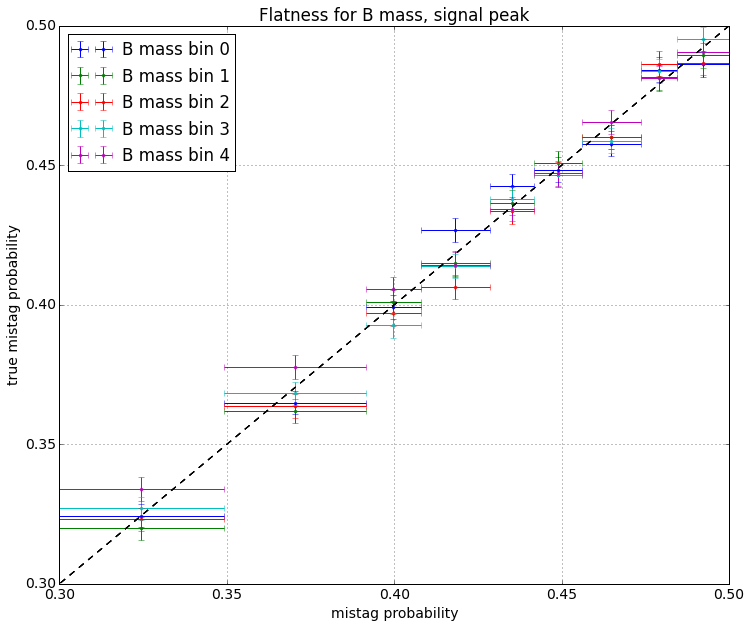

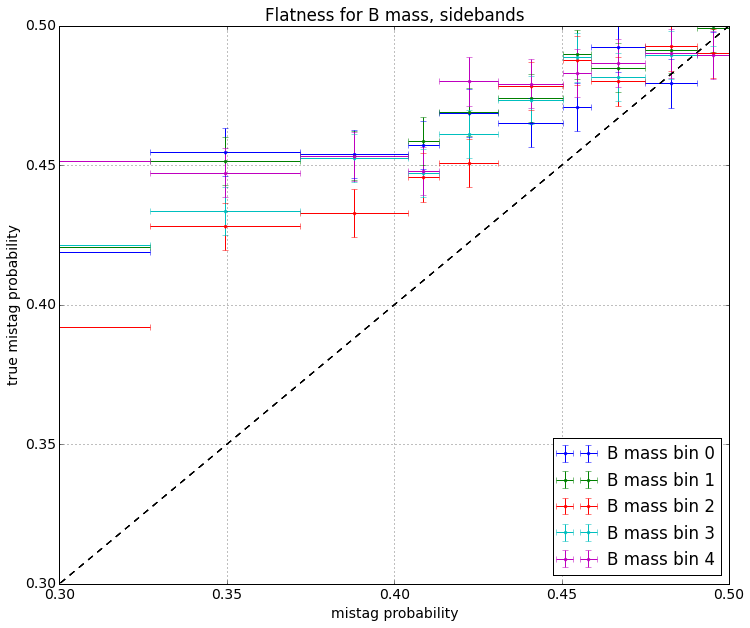

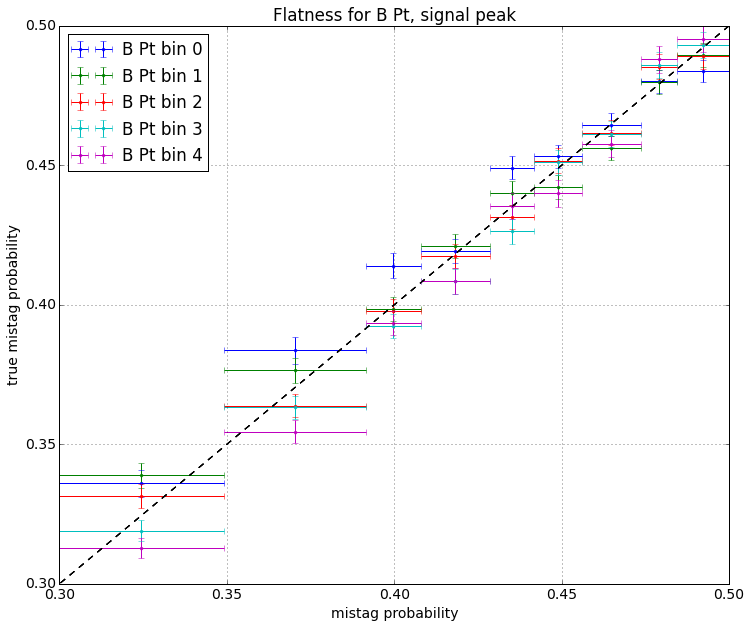

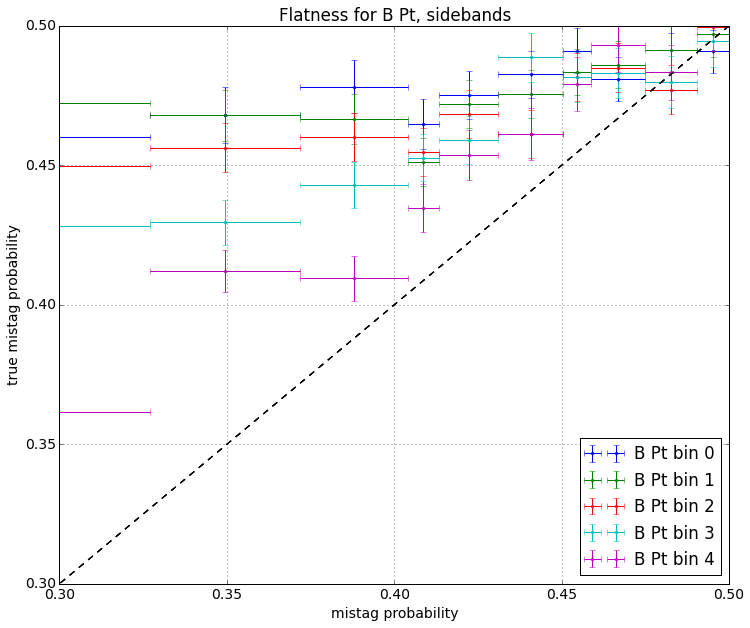

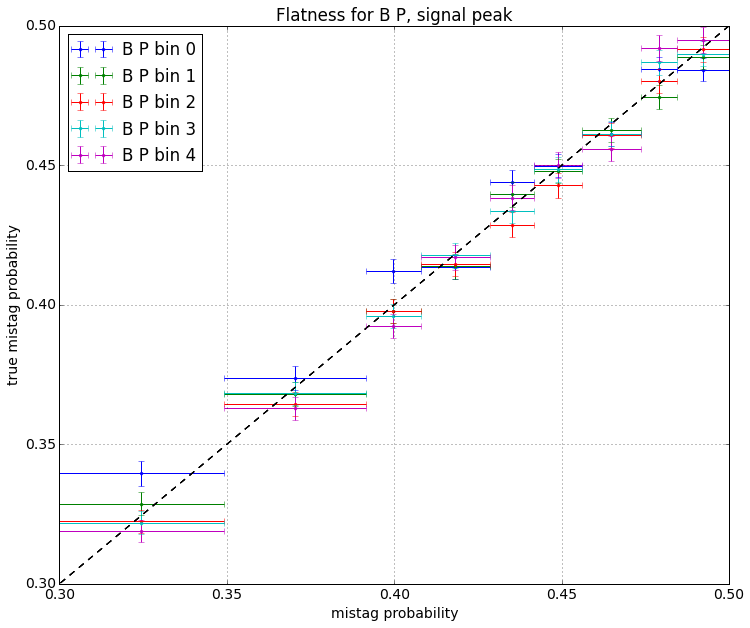

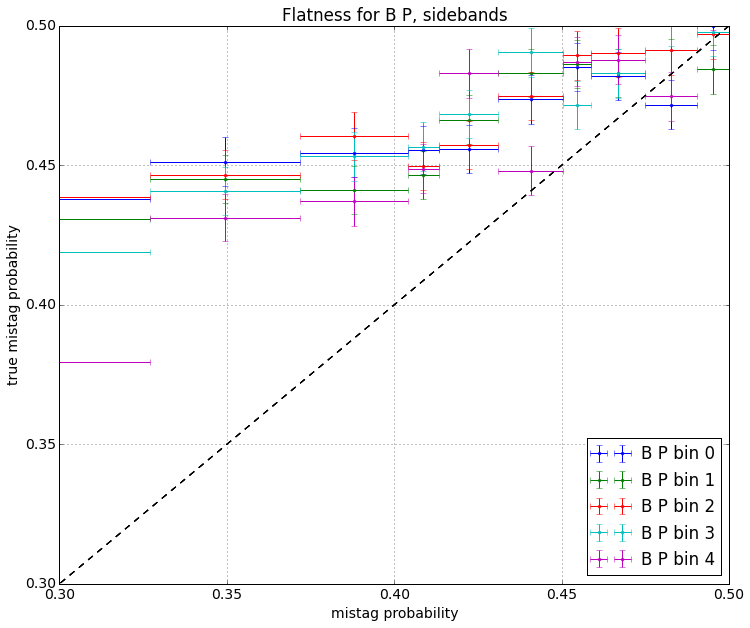

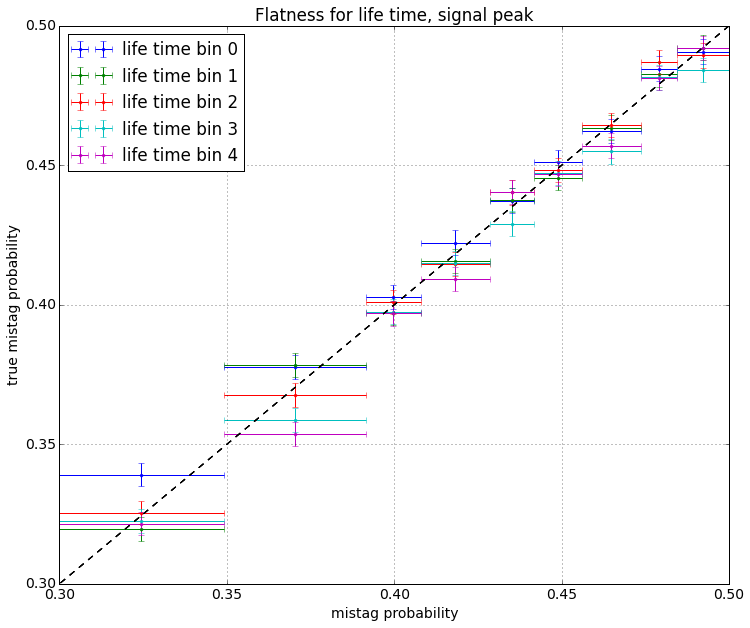

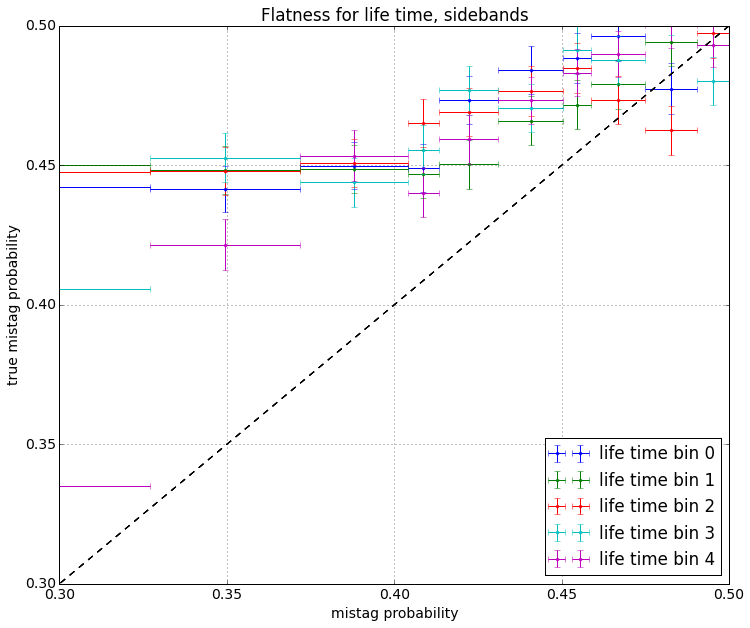

In [63]:
figsize(12, 10)
mask_signal = ((Bmass > 5.27) & (Bmass < 5.3)) & mask
mask_bck = ((Bmass < 5.25) | (Bmass > 5.32)) * mask
for flatness_feature, flatness_name in zip([Bmass, Bpt, Bp, tau], 
                                           ['B mass', 'B Pt', 'B P', 'life time']):
    compute_flatness(Bprob_calibrated[mask_signal], Bsign[mask_signal], Bweight[mask_signal] * 0 + 1, 
                     (Bsign[mask_signal] > -100), flatness_feature[mask_signal],
                     percentile_bins, label=flatness_name, uniform=False)
    legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
    xlim(0.3, 0.5), ylim(0.3, 0.5)
    title('Flatness for %s, signal peak' %flatness_name)
    plt.savefig('img/dependence_sig_{}.png'.format(flatness_name.replace(" ", "_")) , format='png')
    show()
    
    compute_flatness(Bprob_calibrated[mask_bck], Bsign[mask_bck], Bweight[mask_bck] * 0 + 1, 
                     (Bsign[mask_bck] > -100), flatness_feature[mask_bck],
                     percentile_bins, label=flatness_name, uniform=False)
    legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
    xlim(0.3, 0.5), ylim(0.3, 0.5)
    title('Flatness for %s, sidebands' %flatness_name)
    plt.savefig('img/dependence_bck_{}.png'.format(flatness_name.replace(" ", "_")) , format='png')
    show()

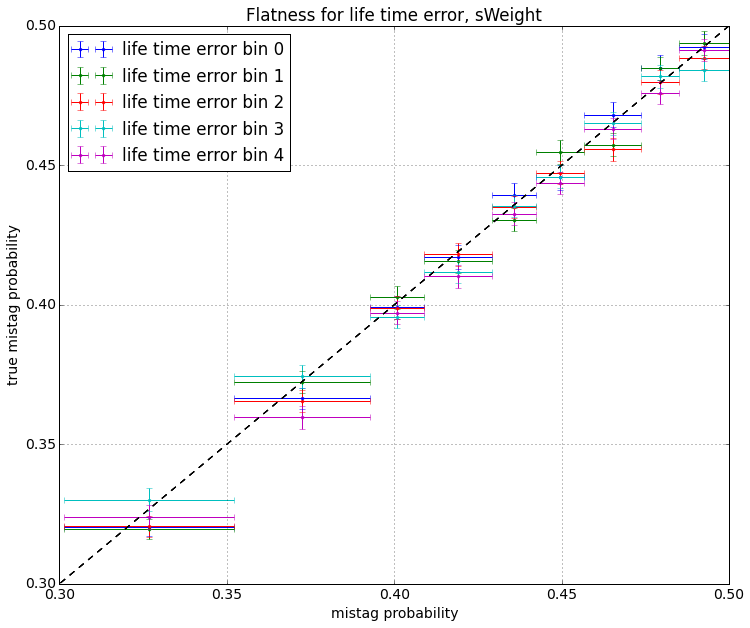

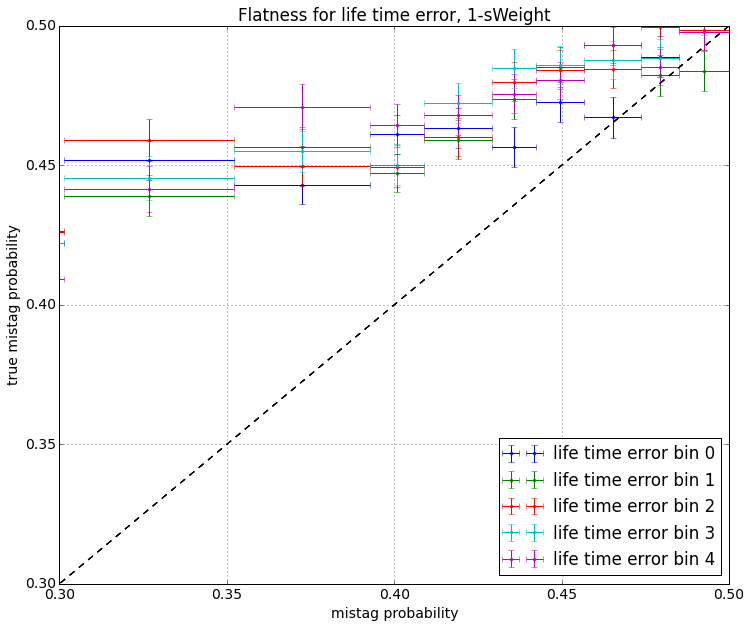

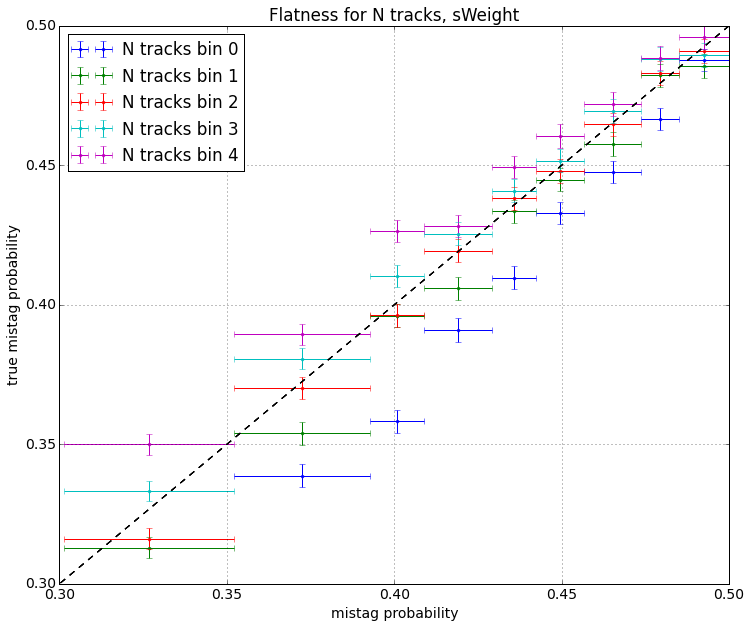

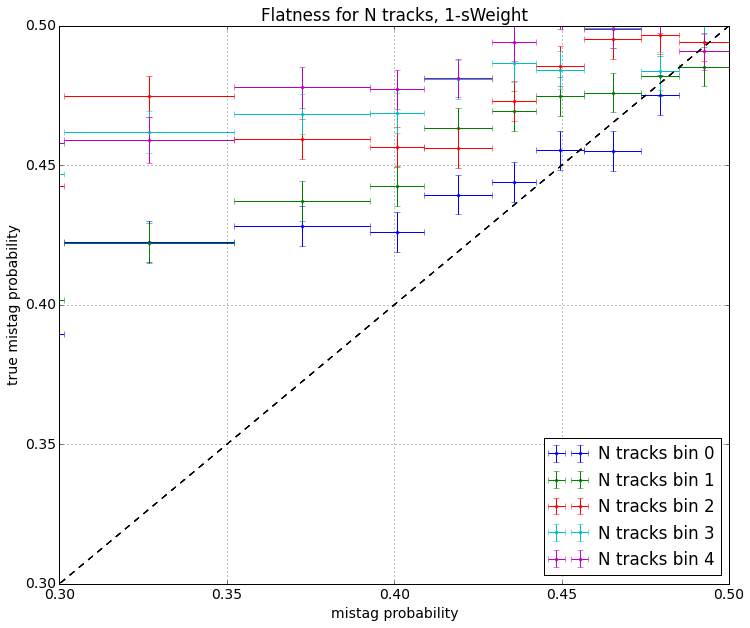

In [64]:
figsize(12, 10)
for flatness_feature, flatness_name in zip([tau_error, ntracks], 
                                           ['life time error', 'N tracks']):
    compute_flatness(Bprob_calibrated[mask], Bsign[mask], Bweight[mask],
                     (Bsign[mask] > -100), flatness_feature[mask],
                     percentile_bins, label=flatness_name, uniform=False)
    legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
    title('Flatness for %s, sWeight' %flatness_name)
    xlim(0.3, 0.5), ylim(0.3, 0.5)
    plt.savefig('img/dependence_sig_{}.png'.format(flatness_name.replace(" ", "_")) , format='png')
    show()
    
    compute_flatness(Bprob_calibrated[mask], Bsign[mask], 1 - Bweight[mask], 
                     (Bsign[mask] > -100), flatness_feature[mask],
                     percentile_bins, label=flatness_name, uniform=False)
    legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
    title('Flatness for %s, 1-sWeight' %flatness_name)
    xlim(0.3, 0.5), ylim(0.3, 0.5)
    plt.savefig('img/dependence_bck_{}.png'.format(flatness_name.replace(" ", "_")) , format='png')
    show()